# 04 — Feature Engineering

Compute and visualize joint angles, normalization, and temporal features from YOLO keypoint sequences.

In [1]:
import sys
sys.path.insert(0, "..")

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from src.features.angles import compute_angle_sequence, compute_all_angles
from src.features.normalize import torso_normalize
from src.features.temporal import compute_velocity, compute_acceleration, smooth_sequence
from src.pose_estimation.keypoint_schema import UNIFIED_JOINTS

# Load manifest
with open("../data/processed/keypoints/manifest.json") as f:
    manifest = json.load(f)

# Load all YOLO keypoints
YOLO_DIR = Path("../data/processed/keypoints/yolo")
keypoints = {}
for vid_id, info in manifest.items():
    npy_path = YOLO_DIR / f"{vid_id}.npy"
    if npy_path.exists():
        keypoints[vid_id] = np.load(npy_path)

correct_ids = sorted([v for v, info in manifest.items() if info["label"] == "correct"])
incorrect_ids = sorted([v for v, info in manifest.items() if info["label"] == "incorrect"])

print(f"Loaded {len(keypoints)} YOLO keypoint sequences")
print(f"  Correct: {len(correct_ids)}, Incorrect: {len(incorrect_ids)}")
print(f"  Frame counts: min={min(len(k) for k in keypoints.values())}, "
      f"max={max(len(k) for k in keypoints.values())}")

Loaded 100 YOLO keypoint sequences
  Correct: 50, Incorrect: 50
  Frame counts: min=45, max=397


## Section 1: Angle Curves

Compute elbow, back alignment, hip, and knee angle time series for sample videos. Visual sanity check that angles look reasonable.

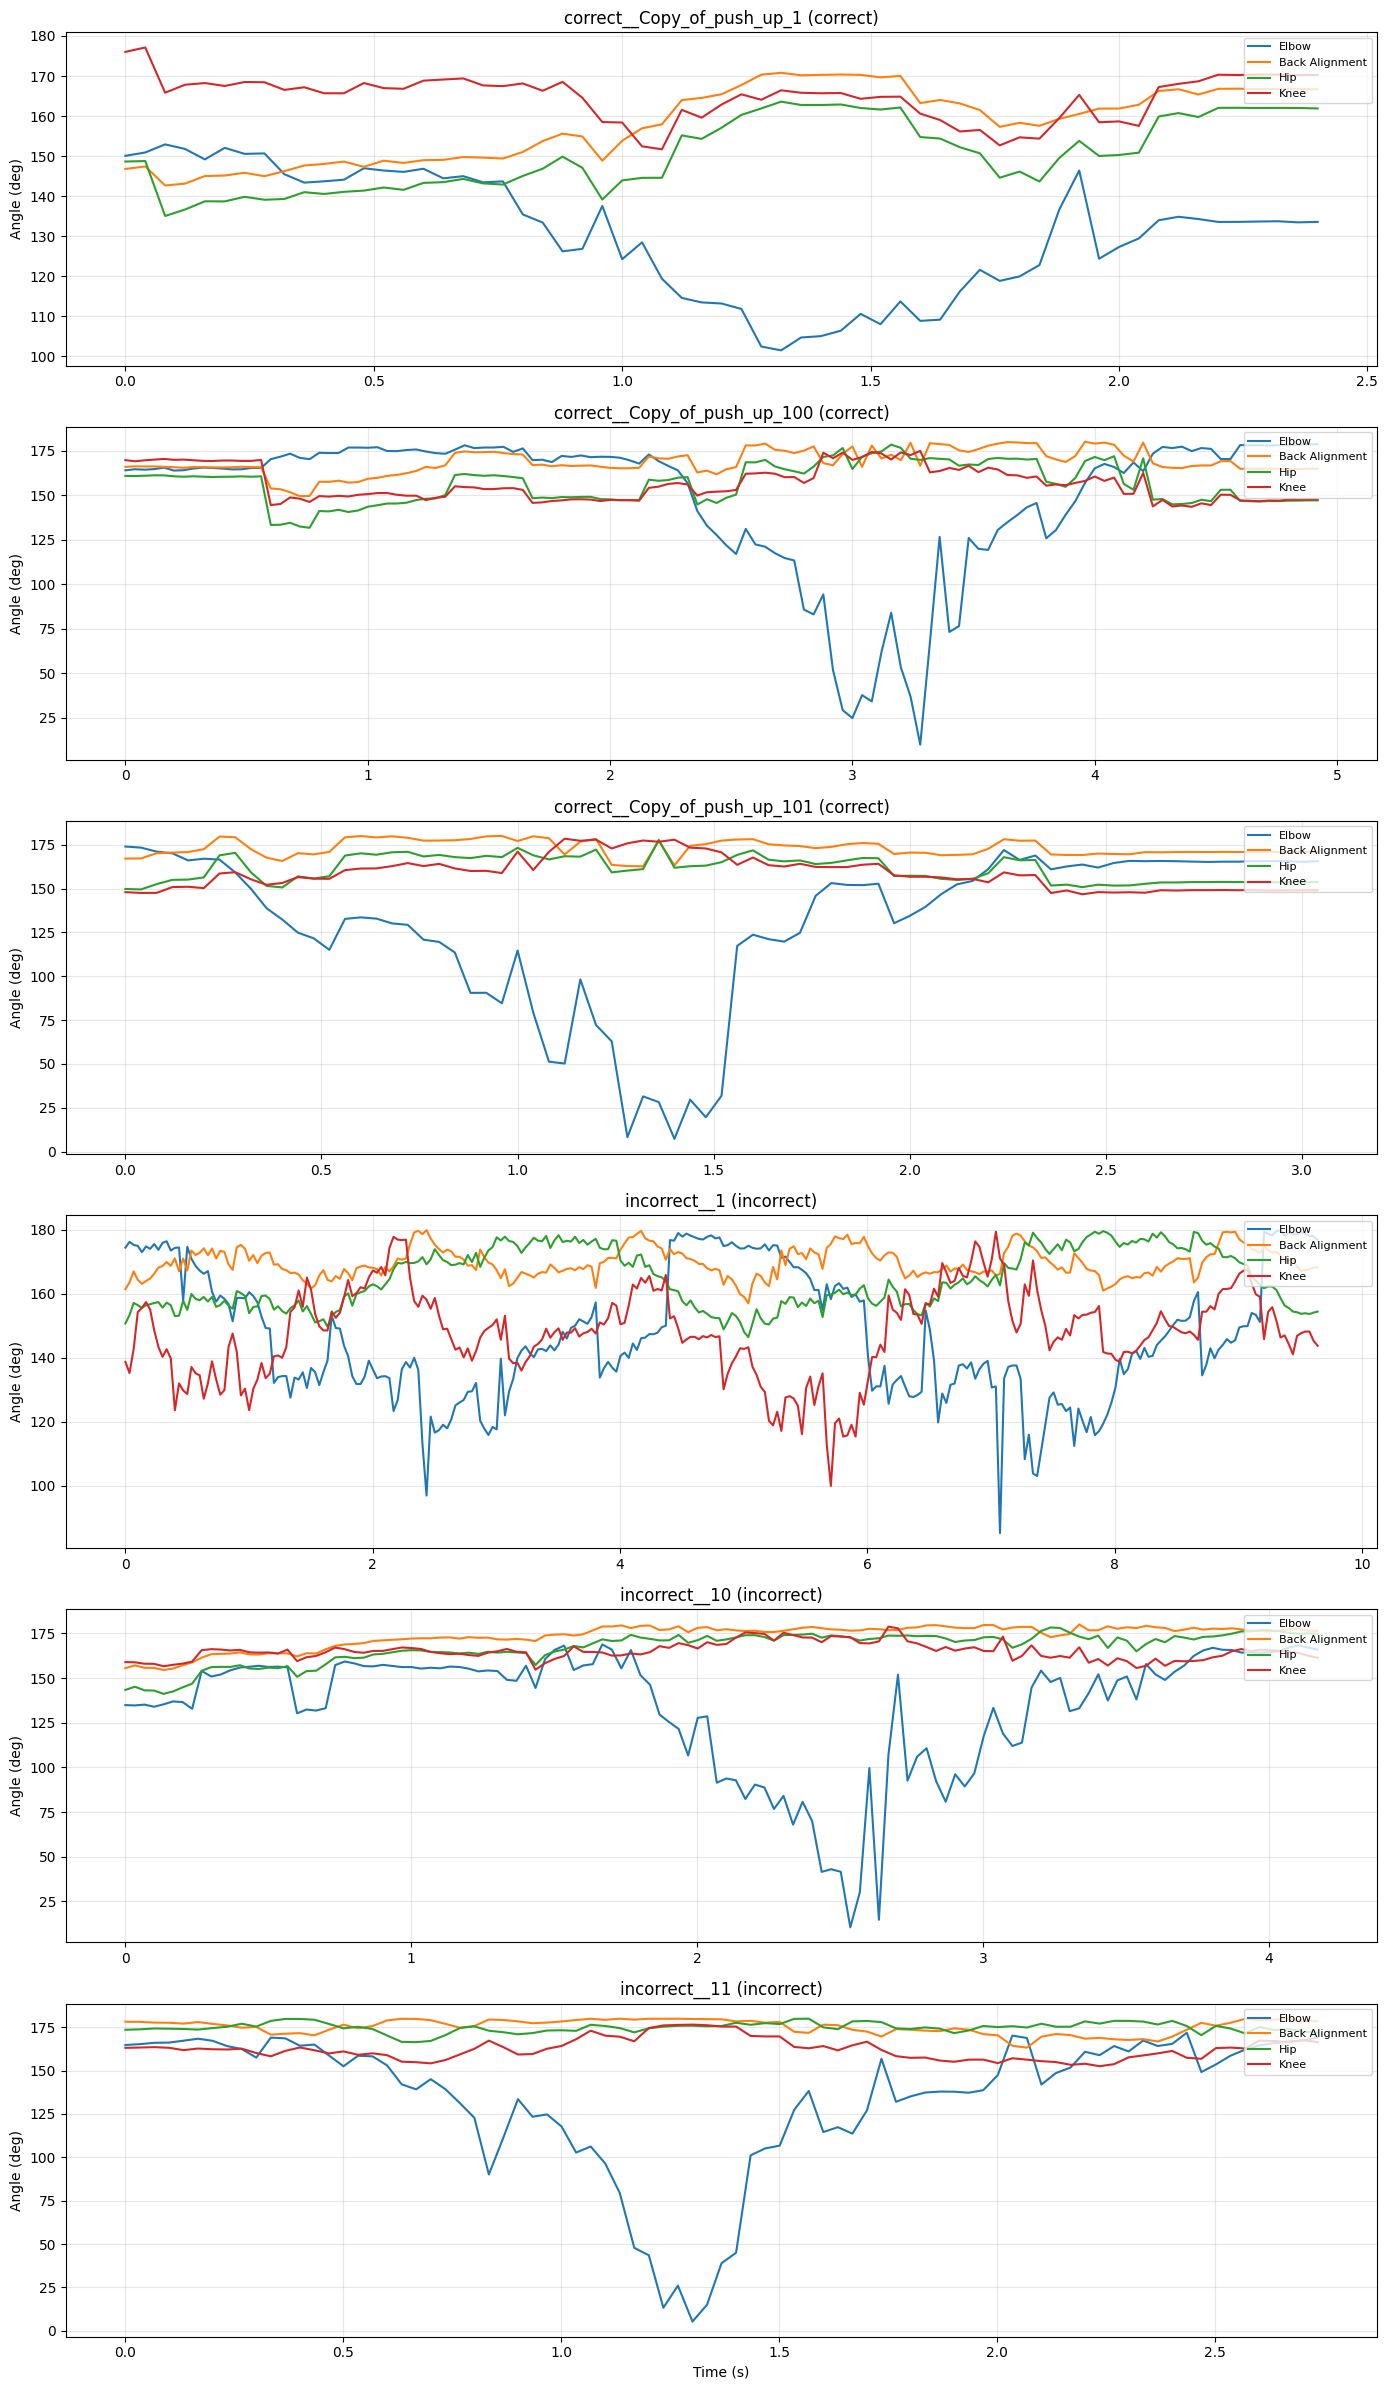

In [2]:
# Select 3 correct + 3 incorrect sample videos
sample_correct = correct_ids[:3]
sample_incorrect = incorrect_ids[:3]
sample_ids = sample_correct + sample_incorrect

angle_names = ["Elbow", "Back Alignment", "Hip", "Knee"]

fig, axes = plt.subplots(len(sample_ids), 1, figsize=(14, 4 * len(sample_ids)))

for i, vid_id in enumerate(sample_ids):
    kps = keypoints[vid_id]
    angles = compute_angle_sequence(kps)
    label = manifest[vid_id]["label"]
    fps = manifest[vid_id]["fps"]
    t = np.arange(len(angles)) / fps

    for j, name in enumerate(angle_names):
        axes[i].plot(t, angles[:, j], label=name)

    axes[i].set_title(f"{vid_id} ({label})")
    axes[i].set_ylabel("Angle (deg)")
    axes[i].legend(loc="upper right", fontsize=8)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig("../outputs/figures/04_angle_curves.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 2: Correct vs Incorrect Distributions

Compute angle sequences for all 100 videos. Compare min, max, mean, and range distributions between correct and incorrect groups.

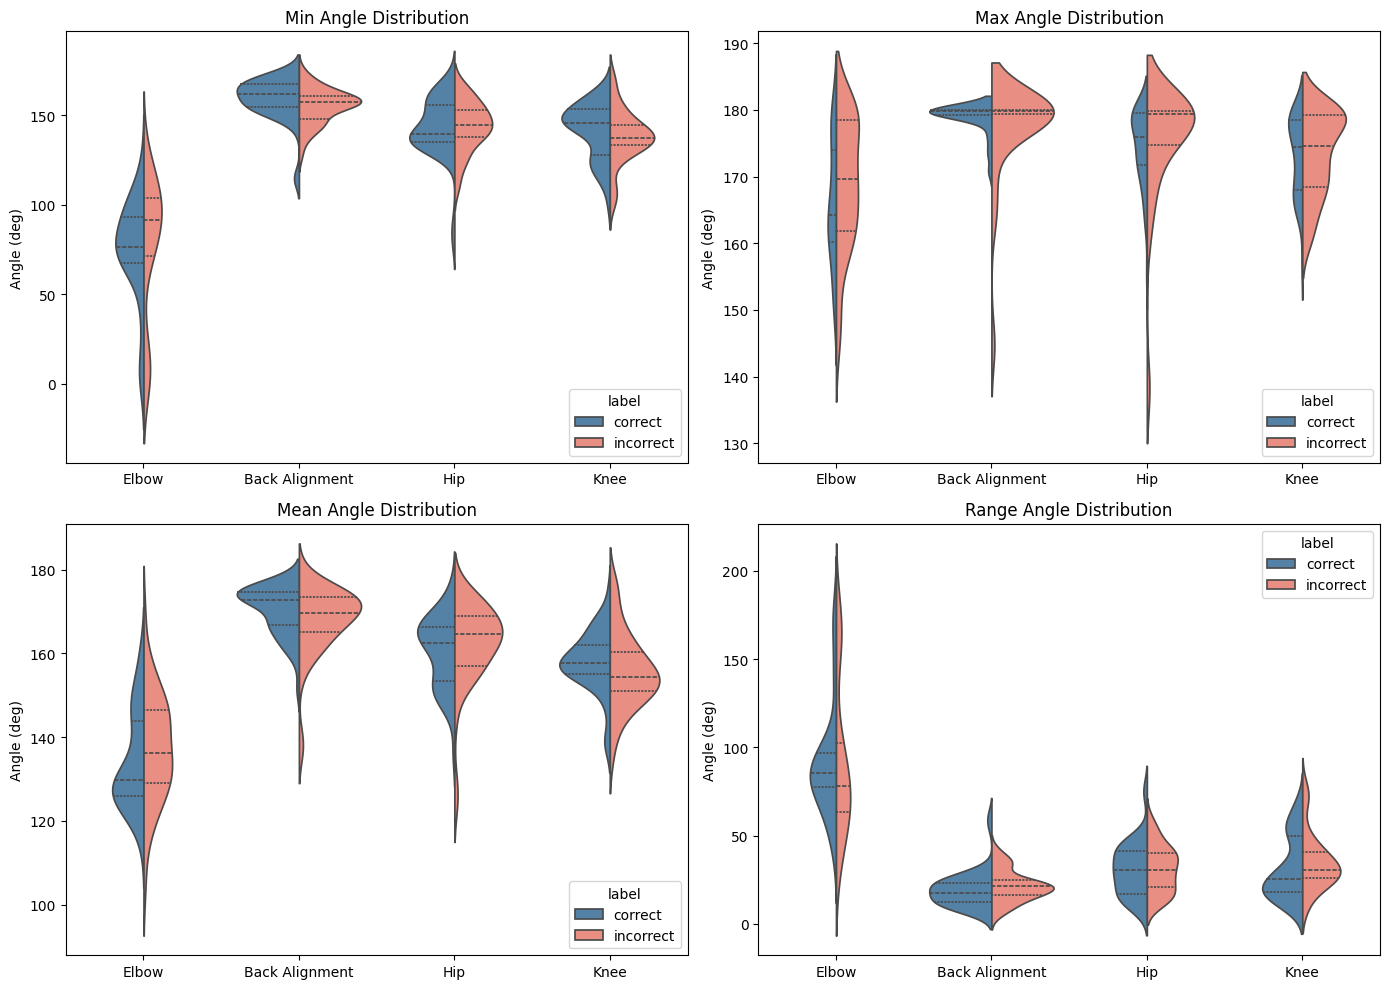

In [3]:
# Compute per-video angle statistics
records = []
all_angle_sequences = {}

for vid_id, kps in keypoints.items():
    angles = compute_angle_sequence(kps)
    all_angle_sequences[vid_id] = angles
    label = manifest[vid_id]["label"]

    for j, name in enumerate(angle_names):
        col = angles[:, j]
        records.append({
            "video": vid_id,
            "label": label,
            "angle": name,
            "min": col.min(),
            "max": col.max(),
            "mean": col.mean(),
            "range": col.max() - col.min(),
        })

df_angles = pd.DataFrame(records)

# Violin plots: compare correct vs incorrect
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
stats = ["min", "max", "mean", "range"]

for idx, stat in enumerate(stats):
    ax = axes[idx // 2][idx % 2]
    sns.violinplot(data=df_angles, x="angle", y=stat, hue="label",
                   split=True, inner="quartile", ax=ax, palette={"correct": "steelblue", "incorrect": "salmon"})
    ax.set_title(f"{stat.capitalize()} Angle Distribution")
    ax.set_xlabel("")
    ax.set_ylabel("Angle (deg)")

plt.tight_layout()
plt.savefig("../outputs/figures/04_angle_distributions.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 3: Normalization

Apply torso normalization and verify that angles are invariant (angles are computed from vectors, so scaling should not change them).

In [4]:
# Verify angle invariance under torso normalization
print("Verifying angle invariance under torso normalization:\n")

for vid_id in sample_ids[:3]:
    kps = keypoints[vid_id]

    # Original angles
    orig_angles = compute_angle_sequence(kps)

    # Normalize each frame, then recompute angles
    norm_kps = np.array([torso_normalize(frame) for frame in kps])
    norm_angles = compute_angle_sequence(norm_kps)

    max_diff = np.abs(orig_angles - norm_angles).max()
    mean_diff = np.abs(orig_angles - norm_angles).mean()
    print(f"  {vid_id}: max diff = {max_diff:.6f} deg, mean diff = {mean_diff:.6f} deg")

print("\nAngles are computed from unit vectors, so uniform scaling preserves them.")
print("Normalization works correctly — angles are invariant to torso scale.")

Verifying angle invariance under torso normalization:

  correct__Copy_of_push_up_1: max diff = 0.000061 deg, mean diff = 0.000008 deg
  correct__Copy_of_push_up_100: max diff = 0.000084 deg, mean diff = 0.000010 deg
  correct__Copy_of_push_up_101: max diff = 0.000259 deg, mean diff = 0.000013 deg

Angles are computed from unit vectors, so uniform scaling preserves them.
Normalization works correctly — angles are invariant to torso scale.


## Section 4: Temporal Features

Compute velocity and acceleration for sample videos. Apply Savitzky-Golay smoothing and compare raw vs smoothed angle curves.

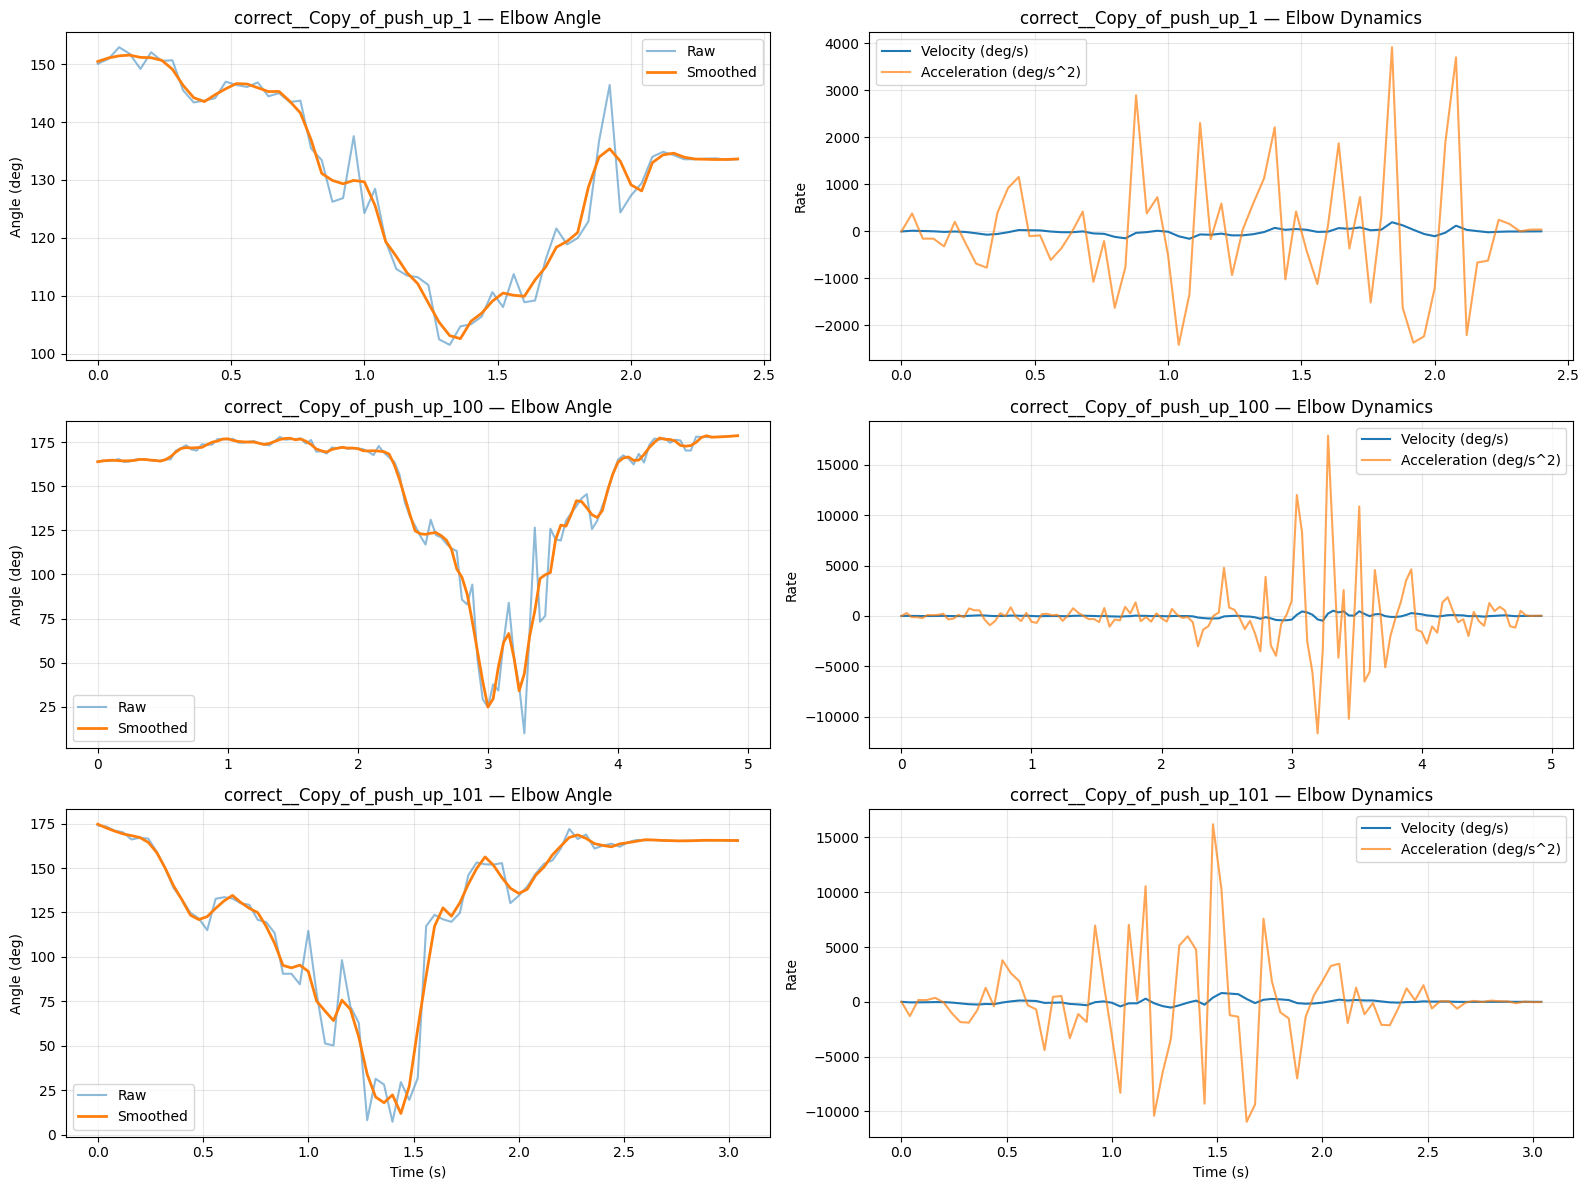

In [5]:
# Compute temporal features for 3 sample videos
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for i, vid_id in enumerate(sample_ids[:3]):
    kps = keypoints[vid_id]
    fps = manifest[vid_id]["fps"]
    angles = compute_angle_sequence(kps)
    t = np.arange(len(angles)) / fps

    # Smooth
    smoothed = smooth_sequence(angles)

    # Velocity & acceleration on smoothed signal
    vel = compute_velocity(smoothed, fps)
    acc = compute_acceleration(smoothed, fps)

    # Left: raw vs smoothed elbow angle
    axes[i, 0].plot(t, angles[:, 0], alpha=0.5, label="Raw")
    axes[i, 0].plot(t, smoothed[:, 0], linewidth=2, label="Smoothed")
    axes[i, 0].set_title(f"{vid_id} — Elbow Angle")
    axes[i, 0].set_ylabel("Angle (deg)")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)

    # Right: velocity and acceleration
    axes[i, 1].plot(t, vel[:, 0], label="Velocity (deg/s)")
    axes[i, 1].plot(t, acc[:, 0], alpha=0.7, label="Acceleration (deg/s^2)")
    axes[i, 1].set_title(f"{vid_id} — Elbow Dynamics")
    axes[i, 1].set_ylabel("Rate")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel("Time (s)")
axes[-1, 1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig("../outputs/figures/04_temporal_features.png", dpi=120, bbox_inches="tight")
plt.show()

## Section 5: Save Features

Save all computed angle sequences as `.npy` files and a summary CSV with per-video statistics.

In [6]:
# Save all angle sequences and summary
FEATURES_DIR = Path("../data/processed/features")
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

summary_records = []
for vid_id, kps in keypoints.items():
    angles = all_angle_sequences[vid_id]
    np.save(FEATURES_DIR / f"{vid_id}.npy", angles)

    label = manifest[vid_id]["label"]
    summary_records.append({
        "video_id": vid_id,
        "label": label,
        "n_frames": len(kps),
        "duration_s": manifest[vid_id]["duration_s"],
        "elbow_mean": angles[:, 0].mean(),
        "elbow_min": angles[:, 0].min(),
        "elbow_max": angles[:, 0].max(),
        "back_mean": angles[:, 1].mean(),
        "back_min": angles[:, 1].min(),
        "back_max": angles[:, 1].max(),
        "hip_mean": angles[:, 2].mean(),
        "hip_min": angles[:, 2].min(),
        "hip_max": angles[:, 2].max(),
        "knee_mean": angles[:, 3].mean(),
        "knee_min": angles[:, 3].min(),
        "knee_max": angles[:, 3].max(),
    })

summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(FEATURES_DIR / "feature_summary.csv", index=False)

print(f"Saved {len(keypoints)} angle sequences to {FEATURES_DIR}/")
print(f"Saved feature_summary.csv with {len(summary_df)} rows")
print()
summary_df.describe().round(2)

Saved 100 angle sequences to ../data/processed/features/
Saved feature_summary.csv with 100 rows



,n_frames,duration_s,elbow_mean,elbow_min,elbow_max,back_mean,back_min,back_max,hip_mean,hip_min,hip_max,knee_mean,knee_min,knee_max
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,109.28,4.18,135.67,75.93,167.39,169.12,157.31,177.88,161.34,143.68,174.80,156.90,139.96,173.28
std,59.16,2.28,12.16,33.92,9.48,7.15,10.96,5.79,9.26,15.45,7.50,8.14,15.17,6.00
min,45.00,1.80,104.15,0.04,145.09,136.46,114.54,144.18,124.05,79.67,138.27,134.75,99.97,156.86
25%,73.50,2.87,126.42,69.24,160.91,166.00,152.79,179.29,155.96,135.47,172.01,152.69,133.01,168.02
50%,92.50,3.54,133.03,82.42,166.19,171.49,157.73,179.87,163.17,142.75,177.97,156.54,142.01,174.52
75%,123.25,4.43,145.99,99.36,177.65,173.82,164.48,179.94,167.15,154.69,179.70,161.87,149.41,178.95
max,397.00,15.88,169.30,127.50,180.00,178.82,175.06,180.00,176.55,170.56,180.00,177.17,170.28,180.00
